In [1]:
import tensorflow as tf
import numpy as np
import scipy

import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import glob, os, sys, gc
import skimage

sys.path.insert(0,'..') # add parent directory to path
from prior_attention import build_prior_attentions
import utils
from config import Config

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras import optimizers
from keras.optimizers import Adam

# this is important to make sure the Config is reloaded when modified
%load_ext autoreload
%autoreload 2
# %pprint

Using TensorFlow backend.


In [2]:
dict(vars(Config))

{'__module__': 'config',
 'main_path': '/home/mikey/Data/POETdataset/PascalImages',
 'class_names': ['dog',
  'aeroplane',
  'boat',
  'bicycle',
  'cat',
  'cow',
  'diningtable',
  'horse',
  'motorbike',
  'sofa'],
 'IMG_SIZE': 480,
 'PATCH_WIDTH': 120,
 'SMALLER_IMG_SIZE': 150,
 'T': 16,
 'new_dir': 'soft_attention_features_120',
 'new_dir_img': 'soft_attention_images_120',
 'name_to_class_dict': {'dog': 0,
  'aeroplane': 1,
  'boat': 2,
  'bicycle': 3,
  'cat': 4,
  'cow': 5,
  'diningtable': 6,
  'horse': 7,
  'motorbike': 8,
  'sofa': 9},
 'train_ids': ['horse_2010_004477.jpg',
  'cat_2010_001351.jpg',
  'horse_2008_006434.jpg',
  'dog_2010_002586.jpg',
  'cat_2008_007239.jpg',
  'cat_2010_002305.jpg',
  'cat_2009_003419.jpg',
  'sofa_2008_004670.jpg',
  'cow_2009_003189.jpg',
  'dog_2010_002808.jpg',
  'horse_2009_000409.jpg',
  'diningtable_2010_004361.jpg',
  'dog_2009_001535.jpg',
  'cat_2011_000973.jpg',
  'cow_2010_001694.jpg',
  'sofa_2011_001192.jpg',
  'cat_2009_001037.

In [3]:
main_path = Config.main_path
class_names = Config.class_names
IMG_SIZE = Config.IMG_SIZE
PATCH_WIDTH = Config.PATCH_WIDTH
SMALLER_IMG_SIZE = Config.SMALLER_IMG_SIZE
T = Config.T
new_dir = Config.new_dir
new_dir_img = Config.new_dir_img
name_to_class_dict = Config.name_to_class_dict
train_ids, test_ids = Config.train_ids, Config.test_ids

In [4]:
def load_data(mode):
    X = []
    y = []
    org_images = []
    all_ids = []
    for class_name, class_number in name_to_class_dict.items():
        classfeatures_path = os.path.abspath(os.path.join('.', new_dir, class_name + '_' + mode + '_features.pkl'))
        classimages_path = os.path.abspath(os.path.join('.', new_dir_img, class_name + '_' + mode + '.pkl'))
        print(classfeatures_path)

        features = utils.load_object(classfeatures_path).reshape(-1,T,2048)
        images = utils.load_object(classimages_path)
        ids = utils.load_object(new_dir + os.path.sep + class_name + '_'+mode+'_names.pkl')
        org_images.append(images)

        print(features.shape)
        X.append(features)
        y.append([class_number] * features.shape[0])
        all_ids.append(ids)

    X = np.concatenate(X)
    y = np.concatenate(y)
    y = keras.utils.to_categorical(y)
    ids = np.concatenate(all_ids)
    org_images = np.concatenate(org_images)
    return X, y, org_images, ids
    
X_train, y_train, images_train, train_ids = load_data(mode='train')
X_test, y_test, images_test, test_ids = load_data(mode='test')

X_train.shape, y_train.shape, images_train.shape, X_test.shape, y_test.shape, images_test.shape

/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_120/dog_train_features.pkl
(1128, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_120/aeroplane_train_features.pkl
(599, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_120/boat_train_features.pkl
(454, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_120/bicycle_train_features.pkl
(480, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_120/cat_train_features.pkl
(943, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_120/cow_train_features.pkl
(265, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_120/diningtable_train_f

((5517, 16, 2048),
 (5517, 10),
 (5517, 150, 150, 3),
 (614, 16, 2048),
 (614, 10),
 (614, 150, 150, 3))

In [16]:
tf.reset_default_graph()

n_epochs = 100
batch_size = 32
T = X_train.shape[1]
lstm_time = 3 #analogous to fixations ?
regularize_attention = True
pretrain_attention = False
prior_attentions_train = build_prior_attentions(utils.load_object('../train_fix.pkl'), T, lstm_time, gauss_sigma=.5)
prior_attentions_test = build_prior_attentions(utils.load_object('../test_fix.pkl'), T, lstm_time, gauss_sigma=.5)

               
X_input = tf.placeholder(tf.float32, [None, T, 2048], name='X')
prior_attentions_input = tf.placeholder(tf.float32, [None, lstm_time, T])
labels = tf.placeholder(tf.int32, [None, y_train.shape[1]], name='labels')

rnn_units = 32

# c,h = utils._get_initial_lstm(X_input[:,:,:], H=rnn_units)

context = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
c = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
h = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
# context = tf.layers.dropout(context, rate=0.1)

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_units)

contexts = []
attentions = []

att_input = tf.nn.tanh(X_input) # squeeze features from Resnet into same scale as context

AttentionDense = tf.layers.Dense(T, activation='tanh')

kernel_reg, activity_reg = None, None
if regularize_attention:
    kernel_reg, activity_reg = (tf.contrib.layers.l2_regularizer(scale=.0005),
                                tf.contrib.layers.l2_regularizer(scale=.0005))

ContextDense = tf.layers.Dense(2048, activation='tanh',
                              kernel_regularizer=kernel_reg,
                              activity_regularizer=activity_reg)
for t in range(lstm_time):
    # encoded lstm context to a specific size 
    context_transformed = ContextDense(context)
#     context_transformed = tf.layers.dropout(context_transformed, rate=0.1)
    
    # how lstm context and patch info relate
    att = tf.einsum('bi,bti->bt', context_transformed, att_input)
#     att_input = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), T, activation='tanh')

#     att = AttentionDense(tf.concat([context, att_input], axis=1))
    att = tf.nn.softmax(att)
    
    lstm_input = tf.einsum('bt,bti->bi', att, X_input)
    
    context, (c, h) = lstm_cell(inputs=lstm_input, state=[c, h])
    context = tf.layers.dropout(context, rate=0.5)
    contexts.append(context)
    attentions.append(att)
    
all_attentions_tensor = tf.transpose(tf.stack(attentions), [1,0,2])
attention_loss = tf.reduce_mean(tf.abs(tf.exp(tf.abs(all_attentions_tensor - tf.nn.softmax(prior_attentions_input))) - 1))
attention_loss = tf.reduce_mean(tf.abs(all_attentions_tensor - (prior_attentions_input)))

Dense = tf.layers.Dense(units=32, activation=tf.nn.relu)
Logits = tf.layers.Dense(units=y_train.shape[1])
probabilities_list = []
for context in contexts:
    dense = Dense(context)
    dense = tf.layers.dropout(dense, rate=0.7)

    # Logits Layer
    logits = Logits(dense)
    logits = tf.layers.dropout(logits, rate=0.7)

    classes = tf.argmax(logits, axis=1)
    probabilites = tf.nn.softmax(logits)
    probabilities_list.append(probabilites)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))
l2_loss = tf.losses.get_regularization_loss()
loss += l2_loss

regular_loss_multiplier = tf.placeholder_with_default(1.0, shape=(), name='regular_loss_multiplier')
attention_loss_multiplier = tf.placeholder_with_default(0., shape=(), name='attention_loss_multiplier')

final_loss = regular_loss_multiplier * loss + attention_loss_multiplier * attention_loss

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(
    loss=final_loss,
    global_step=tf.train.get_global_step()
)

accuracy = tf.reduce_mean(tf.cast(tf.equal(classes, tf.argmax(labels, 1)), tf.float32))

init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

Crucial points for high accuracy:
- regularization on attention
- shuffle after every epoch
- lstm time doesn't matter much (run experiments)
- some dropout to make sure it isn't stuck in local minima

In [8]:
saver = tf.train.Saver(max_to_keep=1)
with tf.Session() as sess:
    sess.run(init)
    
    training_attention = pretrain_attention
    learning_rate_ = 0.0001
    if training_attention:
        learning_rate_ = 0.00001
    
    changed_learning_rate = False
    train_acc_list = []
    acc_list = []
    for epoch in range(n_epochs):
        if training_attention: # training attention
            att_loss_multiplier_value = 1.
            regular_loss_multiplier_value = 0.
        elif pretrain_attention: # switched from training attention to not training
            att_loss_multiplier_value = 10.
            regular_loss_multiplier_value += .1
            if regular_loss_multiplier_value > 1:
                regular_loss_multiplier_value = 1.
                att_loss_multiplier_value = 0.
        else: # wasn't training attention in the first place
            att_loss_multiplier_value = 0.
            regular_loss_multiplier_value = 1.
            
        print("Epoch:", epoch)
        train_acc = []
        att_losses = []
        for b in range(0, X_train.shape[0], batch_size):
            _, acc, loss_, att_loss_ = sess.run([train_op, accuracy, final_loss, attention_loss], feed_dict={
                                                            X_input: X_train[b:b+batch_size],
                                                            prior_attentions_input: prior_attentions_train[b:b+batch_size],
                                                            labels: y_train[b:b+batch_size],
                                                            learning_rate: learning_rate_,
                                                            attention_loss_multiplier: att_loss_multiplier_value,
                                                            regular_loss_multiplier: regular_loss_multiplier_value
                                                        })
            train_acc.append(acc)
            att_losses.append(att_loss_)
            
        # reshuffle after every epoch
        if not training_attention:
            X_train, y_train, prior_attentions, images_train = \
                utils.unison_shuffled_copies([X_train, y_train, prior_attentions_train, images_train])
            
            acc, context_, atts_, test_proba_, probabilities_list_, att_loss_test = \
                sess.run([accuracy,
                          context, all_attentions_tensor, probabilites,
                          probabilities_list,
                         attention_loss], 
                         feed_dict={
                                    X_input: X_test,
                                    labels: y_test,
                                    prior_attentions_input: prior_attentions_test,
                                    })
            if acc > 0.8 and not changed_learning_rate:
                learning_rate_ = learning_rate_ / 10.
                changed_learning_rate = True
                print("Adjusted learning rate to", learning_rate_)

            if acc > 0.97:
                break
        else:
            acc, context_, atts_, test_proba_, probabilities_list_, att_loss_test = \
                sess.run([accuracy,
                          context, all_attentions_tensor, probabilites,
                          probabilities_list,
                         attention_loss], 
                         feed_dict={
                                    X_input: X_test,
                                    labels: y_test,
                                    prior_attentions_input: prior_attentions_test,
                                    })
                     
        print("Train:", np.mean(train_acc))
        print("Test:", acc)
        print("Attention loss", np.mean(att_losses))
        print("Attention loss test", att_loss_test)
        train_acc_list.append(np.mean(train_acc))
        acc_list.append(acc)
        train_acc = []
        att_losses = []
        
        if len(acc_list) > 1 and acc > np.max(acc_list[:-1]):
            saver.save(sess, './checkpoint/model-with-attention')
        
#         0.0303
#         0.111
        if training_attention and att_loss_test < 0.05:
            training_attention = False
            print("Done training prior attention")
            learning_rate_ = learning_rate_ * 10
#             break
#         print(atts_[0])

Epoch: 0
Train: 0.2274622
Test: 0.31270358
Attention loss 0.09826725
Attention loss test 0.0973491
Epoch: 1
Train: 0.3363856
Test: 0.38599348
Attention loss 0.09754647
Attention loss test 0.09711444
Epoch: 2
Train: 0.49000946
Test: 0.54723126
Attention loss 0.09702852
Attention loss test 0.097367264
Epoch: 3
Train: 0.6186916
Test: 0.6237785
Attention loss 0.097102724
Attention loss test 0.096015476
Epoch: 4
Train: 0.7089262
Test: 0.6905537
Attention loss 0.09729988
Attention loss test 0.09550678
Epoch: 5
Train: 0.76510394
Test: 0.72801304
Attention loss 0.09696239
Attention loss test 0.095314234
Epoch: 6
Train: 0.79842436
Test: 0.74592835
Attention loss 0.09743059
Attention loss test 0.097203754
Epoch: 7
Train: 0.8267842
Test: 0.78013027
Attention loss 0.09824563
Attention loss test 0.09684523
Epoch: 8
Train: 0.84765446
Test: 0.7687296
Attention loss 0.097244084
Attention loss test 0.09610458
Epoch: 9
Train: 0.8595626
Test: 0.7703583
Attention loss 0.09760001
Attention loss test 0.0967

KeyboardInterrupt: 

In [20]:
saver = tf.train.Saver(max_to_keep=1)
with tf.Session() as sess:
    sess.run(init)
#     new_saver = tf.train.import_meta_graph('./checkpoint/model-with-attention.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoint'))

    acc, context_, atts_, test_proba_, probabilities_list_, att_loss_test = \
        sess.run([accuracy,
                  context, all_attentions_tensor, probabilites,
                  probabilities_list,
                 attention_loss], 
                 feed_dict={
                            X_input: X_test,
                            labels: y_test,
                            prior_attentions_input: prior_attentions_test,
                            })
    print("Test:", acc)
    print("Attention loss", np.mean(att_losses))

INFO:tensorflow:Restoring parameters from ./checkpoint/model-with-attention
Test: 0.82247555
Attention loss 0.09303166


In [21]:
np.array(context_).shape, np.array(atts_).shape

((614, 32), (614, 3, 16))

In [22]:
atts_ = np.array(atts_)
images_test = np.array(images_test)
probabilities_list_ = np.array(probabilities_list_)

atts_.shape

(614, 3, 16)

In [23]:
unique, counts = np.unique(np.argmax(y_test, axis=-1), return_counts=True)
class_to_name_dict = {v:k for k,v in name_to_class_dict.items()}
unique = np.array([class_to_name_dict[u] for u in unique])

np.asarray((unique, counts)).T

array([['dog', '126'],
       ['aeroplane', '67'],
       ['boat', '50'],
       ['bicycle', '53'],
       ['cat', '105'],
       ['cow', '30'],
       ['diningtable', '47'],
       ['horse', '48'],
       ['motorbike', '50'],
       ['sofa', '38']], dtype='<U21')

In [24]:
unique, counts = np.unique(np.argmax(test_proba_, axis=-1), return_counts=True)
class_to_name_dict = {v:k for k,v in name_to_class_dict.items()}
unique = np.array([class_to_name_dict[u] for u in unique])

np.asarray((unique, counts)).T

array([['dog', '125'],
       ['aeroplane', '61'],
       ['boat', '54'],
       ['bicycle', '47'],
       ['cat', '102'],
       ['cow', '21'],
       ['diningtable', '56'],
       ['horse', '51'],
       ['motorbike', '56'],
       ['sofa', '41']], dtype='<U21')

In [25]:
test_fix = utils.load_object('../test_fix.pkl')
test_ids = utils.load_object('../test_ids.pkl')

name_to_fix_test = {name:fix for fix, name in zip(test_fix, test_ids)}

(3, 30, 10)
aeroplane_2011_002552.jpg
[[0.4432     0.32891566]
 [0.6384     0.22334337]
 [0.5263     0.42078313]]
horse 0.3591139
cow 0.15888613
bicycle 0.076858275
boat 0.07120051
sofa 0.067794874
dog 0.06287323
aeroplane 0.057163052
motorbike 0.05653082
diningtable 0.046211734
cat 0.043367483
(480, 480, 3)
0.06660060729691353


/home/mikey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/mikey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mikey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/mikey/.local/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64


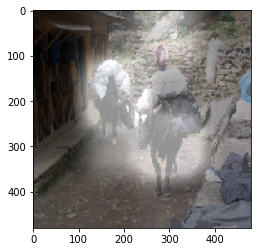

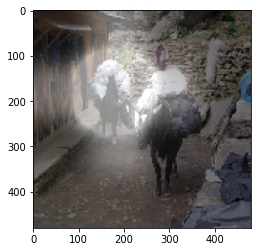

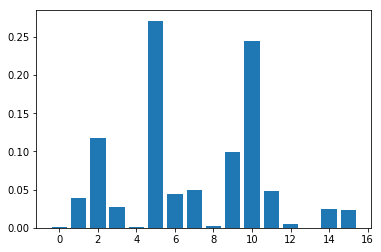

horse 0.67837876
cow 0.21086255
dog 0.07154132
sofa 0.009813081
bicycle 0.007820656
cat 0.006007526
motorbike 0.004897216
aeroplane 0.0045004725
boat 0.004227248
diningtable 0.0019510987
(480, 480, 3)
0.10017480352107688


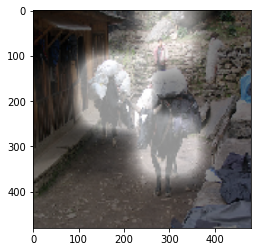

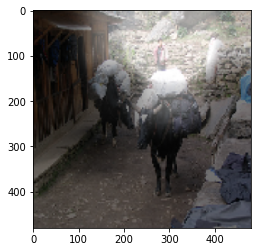

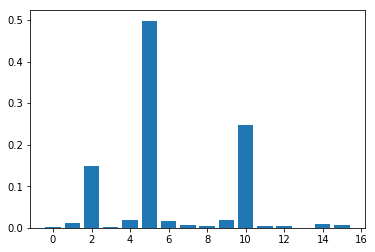

horse 0.90728045
cow 0.06405791
dog 0.019944329
bicycle 0.002418834
motorbike 0.0021018612
sofa 0.0017087188
aeroplane 0.000979207
boat 0.00066857267
cat 0.00065856776
diningtable 0.0001816343
(480, 480, 3)
0.09190471031692926


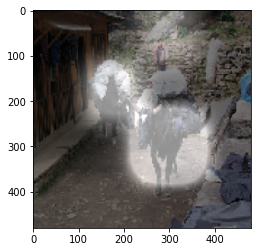

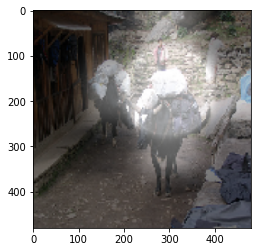

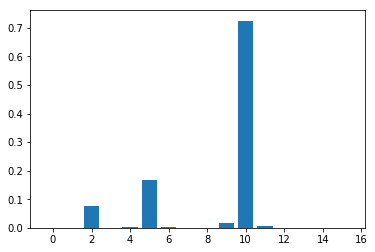

In [26]:
from scipy import signal
from scipy import ndimage

def get_attention_result(img, attention, patches_n, img_size, patch_width, scale = 8, gauss_sigma=None):
    result = np.zeros_like(img)
    for attended_patch_n in range(patches_n):
        att_prob = attention[attended_patch_n]

        row = int(attended_patch_n/(img_size/patch_width))
        col = int(attended_patch_n%(img_size/patch_width))

        from_y = row*patch_width
        to_y = from_y+patch_width

        from_x = col*patch_width
        to_x = from_x+patch_width
        
        result[from_y:to_y, from_x:to_x, :] = np.ones_like(result[from_x:to_x,from_y:to_y,:]) * 255 * att_prob
    
    result = result / 255.
    if gauss_sigma:
        result = ndimage.gaussian_filter(result, sigma=gauss_sigma)
    
    result = result * scale
    result[result > 1] = 1
    
    img = img / 255.
    return utils.normalize((scale/20) * img + result)

class_name = 'cow'
class_id = name_to_class_dict[class_name]
class_mask = np.argmax(y_test, axis=1) == class_id
class_images = images_test[class_mask]
class_test_proba = test_proba_[class_mask]
class_proba_list = probabilities_list_[:,class_mask,:]
class_atts = atts_[class_mask,:,:]
class_true_atts = prior_attentions_test[class_mask]
print(class_proba_list.shape)
image_n = 8
rescale = IMG_SIZE / SMALLER_IMG_SIZE
image_name = np.array(test_ids)[class_mask][image_n]

print(np.array(test_ids)[class_mask][image_n])
print(name_to_fix_test[image_name])

for t in range(atts_.shape[1]):
    image = class_images[image_n]
    proba_res = class_proba_list[t,image_n,:]
#     print(proba_res)
#     print(class_to_name_dict[np.argmax(proba_res)])
    proba_res = [(i, proba) for i, proba in enumerate(proba_res)]
    proba_res.sort(key= lambda pair: pair[1], reverse=True)
#     print(proba_res)
    for i, proba in enumerate(proba_res):
        print(class_to_name_dict[proba[0]], proba[1])
    
    
    if rescale != 1:
        chosen_img = np.array(utils.normalize(skimage.transform.rescale(image.copy(), rescale))) * 500
    else:
        chosen_img = image.copy()
    print(chosen_img.shape)
        
    chosen_attention = class_atts[image_n,t,:]
    chosen_true_attention = class_true_atts[image_n,t,:]
    print(np.mean(np.abs(chosen_attention - chosen_true_attention)))
    
    result = get_attention_result(chosen_img, chosen_attention, T, IMG_SIZE, PATCH_WIDTH, scale=8, gauss_sigma=24)
    plt.imshow(result)
    plt.show()
    
    result = get_attention_result(chosen_img, chosen_true_attention, T, IMG_SIZE, PATCH_WIDTH, scale=8, gauss_sigma=24)
    plt.imshow(result)
    plt.show()
    
    plt.bar(range(atts_.shape[2]), chosen_attention)
    plt.show()

In [ ]:
y_pred_proba = test_proba_

y_pred = np.argmax(y_pred_proba, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)

y_test_argmax.shape



plt.figure(figsize=(12,12))
fig = plot_confusion_matrix(y_test_argmax, y_pred, class_names, normalize=True)

In [ ]:
class_proba_list.shape

In [ ]:
# files_list = [glob.glob(os.path.join(main_path, '%s*' %class_)) for class_ in class_names]

# ids_ = []
# final_files_list = []
# labels = []
# for label, files in enumerate(files_list):
#     one_list = []
#     for file in files:
#         id_ = ''.join(file.split('/')[-1].split('.')[0].split('_')[1:])
#         if id_ not in ids_:
#             one_list.append(file)
#             ids_.append(id_)
#             labels.append(label)
#     final_files_list.append(one_list)
    

# files_dict = {class_name.replace('*', ''): class_files for class_name, class_files in zip(class_names, final_files_list)}